In [1]:
import os
import numpy as np 
import ephem
import surveysim.stats
import desisurvey
import astropy.io
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table

# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
_dir = '/global/cscratch1/sd/chahah/desisurvey_output/fork'

In [3]:
def surveysim_summary(_file):
    fstats = os.path.join(_dir, 'stats_%s.fits' % _file)
    stats = surveysim.stats.SurveyStatistics()
    stats.tiles = desisurvey.tiles.Tiles(tiles_file=os.path.join(_dir, 'tiles-main.ecsv'))
    with astropy.io.fits.open(fstats, memmap=None) as hdus:
        header = hdus[1].header

        comment = header['COMMENT']
        if header['TILES'] != stats.tiles.tiles_file:
            raise ValueError('Header mismatch for TILES.')
        if header['START'] != stats.start_date.isoformat():
            print(header['START'])
            print(stats.start_date.isoformat())
            raise ValueError('Header mismatch for START.')
        if header['STOP'] != stats.stop_date.isoformat():
            raise ValueError('Header mismatch for STOP.')
        stats._data[:] = hdus['STATS'].data

    fexps = os.path.join(_dir, 'exposures_%s.fits' % _file)
    exps = fits.getdata(fexps, 'exposures')
    
    stats.summarize()
    stats.plot()
    plt.show()
    
    actual = np.cumsum(stats._data['completed'], axis=0)[:,0]
    print('%.3f margins' % (1 - np.arange(len(actual))[actual < actual[-1] - 2][-1]/len(actual)))
    
    mayall = ephem.Observer()
    mayall.lat = '-111.599'
    mayall.lon = '31.963'
    mayall.date = Time(exps['MJD'][0], format='mjd').iso

    moon = ephem.Moon()
    moon.compute(mayall)

    
    # date when exposures were taken
    t_exps = Time(exps['MJD'], format='mjd')

    mjds = np.linspace(exps['MJD'].min(), exps['MJD'].min() + 365, 250)
    moon_radec = []
    for mjd in mjds:
        mayall.date = Time(mjd, format='mjd').iso  
    
        moon.compute(mayall)

        # Time(mjd, format='mjd').iso
        moon_radec.append([mjd, np.degrees(moon.ra), np.degrees(moon.dec)])           
    
    moon_radec = np.array(moon_radec)

    clrs = ['C3', 'C1', 'C2', 'C0']
    
    fig = plt.figure(figsize=(16, 8))
    for year in range(5): 
        bynowyear = (t_exps.decimalyear >= t_exps.decimalyear.min()) & (t_exps.decimalyear < (t_exps.decimalyear.min() + year + 1))
        sub = fig.add_subplot(2,3,year+1)
        # plot moon position
        sub.plot(-((moon_radec[:,1] + 360 - 120) % 360), moon_radec[:,2], c='k', lw=0.0, marker=',')
        sub.plot(-(((moon_radec[:,1] + 360 - 120) % 360) - 360), moon_radec[:,2], c='k', lw=0.0, marker=',')

        for _pass in range(4): 
            # tiles that were observed this year in this pass
            is_pass = (stats.tiles.tilepass == _pass) & (stats.tiles.tileprogram == 'BRIGHT')
            is_year = np.in1d(stats.tiles.tileID[is_pass], exps[bynowyear]['TILEID'])
                
            _ra = np.remainder(stats.tiles.tileRA[is_pass][is_year] + 360 - 120, 360)
            _ra[_ra > 180] -= 360
            _ra =- _ra
            sub.scatter(_ra, stats.tiles.tileDEC[is_pass][is_year], s=5, c=clrs[_pass])

        sub.set_xlim(-180, 180)
        sub.set_ylim(-55., 90.)
        sub.text(0.95, 0.95, 'Year %i' % (year+1), transform=sub.transAxes, ha='right', va='top', fontsize=20)
        
        xticks = np.array([-150, 0, 150])
        sub.set_xticks(xticks)
        tick_labels = np.array([270, 120, -30])
        sub.set_xticklabels(tick_labels)

        if year not in [0, 3]: 
            sub.set_yticklabels([])
        if year < 2: 
            sub.set_xticklabels([])
    sub = fig.add_subplot(2, 3, 6)
    sub.axis('off')
    sub.scatter([], [], c='C3', label='Pass 1')
    sub.scatter([], [], c='C1', label='Pass 2')
    sub.scatter([], [], c='C2', label='Pass 3')
    sub.scatter([], [], c='C0', label='Pass 4')

    sub.legend(loc='upper left', fontsize=25, handletextpad=0, markerscale=2)
            
    bkgd = fig.add_subplot(111, frameon=False)
    bkgd.set_xlabel(r'RA (deg)', labelpad=10, fontsize=25) 
    bkgd.set_ylabel(r'Dec (deg)', labelpad=10, fontsize=25) 
    bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    
    tileids, tileras, tiledecs, years, passes = [], [], [], [], []
    for _pass in range(4): 
        # tiles that were observed this year in this pass
        is_pass = (stats.tiles.tilepass == _pass) & (stats.tiles.tileprogram == 'BRIGHT')

        for year in range(5): 
            bynowyear = (t_exps.decimalyear >= t_exps.decimalyear.min() + year) & (t_exps.decimalyear < (t_exps.decimalyear.min() + year + 1))
            is_year = np.in1d(stats.tiles.tileID[is_pass], exps[bynowyear]['TILEID'])
            
            tileids.append(stats.tiles.tileID[is_pass][is_year])
            tileras.append(stats.tiles.tileRA[is_pass][is_year])
            tiledecs.append(stats.tiles.tileDEC[is_pass][is_year])
            passes.append(np.repeat(_pass, np.sum(is_year)))
            years.append(np.repeat(year, np.sum(is_year)))
            
    return fig, [tileids, tileras, tiledecs, years, passes]

# with BGS sky model

INFO:tiles.py:391:read_tiles_table: Removing the following programs from the tile file: EXTRA
Scheduled 13049.267 hr Open 74.884% Live 65.173%
PROG         TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
BRIGHT   5676/5676 19494  7137 124 12357  33 1138.2s 176.2s 152.6s
DARK     9929/9929 14549 11673  16  2876  12 1658.4s 163.6s  20.3s


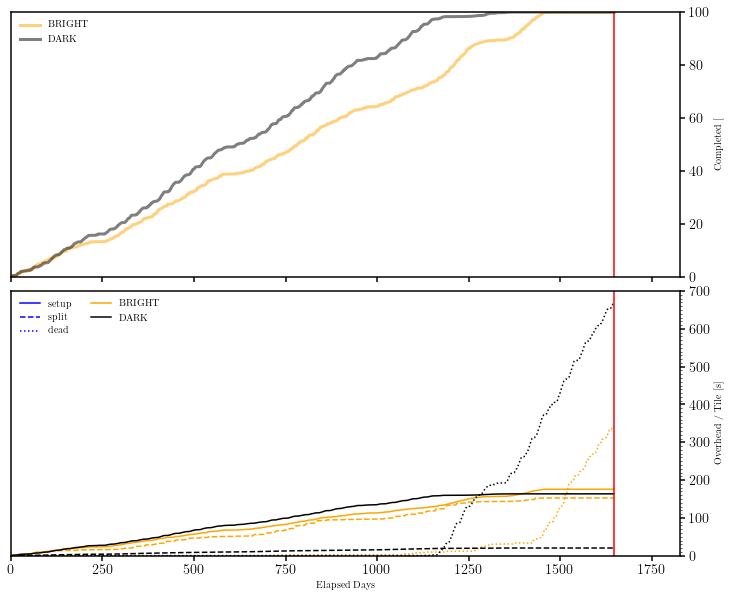

0.197 margins


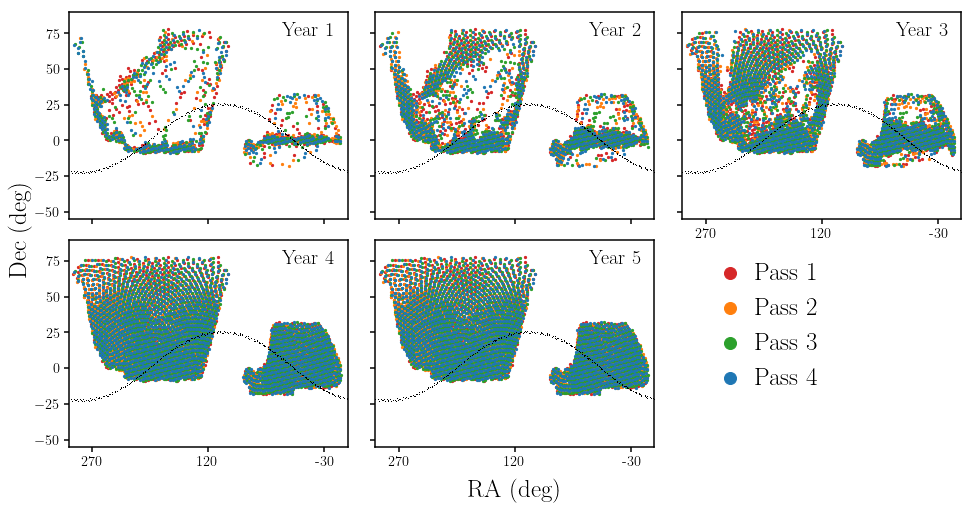

In [4]:
fig, fig_data = surveysim_summary('fork_efftime180s_surveyops')
fig.savefig('figs/strategysim_ch.pdf', bbox_inches='tight')

In [12]:
np.savetxt('dat/fig6_surveysim.dat', 
           np.vstack([np.concatenate(fig_data[0]), np.concatenate(fig_data[1]), np.concatenate(fig_data[2]), np.concatenate(fig_data[3]) + 1, np.concatenate(fig_data[4]) + 1]).T, 
           fmt='%i %f %f %i %i', 
           header='BGS Survey Sim\n TILE ID, RA, DEC, YEAR, PASS')

# with default `surveysim` sky model
assumes a fixed moon up factor for sky levels

INFO:tiles.py:391:read_tiles_table: Removing the following programs from the tile file: EXTRA
Scheduled 10917.487 hr Open 73.818% Live 78.642%
PROG         TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
BRIGHT   5676/5676 12254  6915 107  5339   9 1106.6s 170.6s  65.9s
DARK     9929/9929 14691 11627  18  3064  11 1665.3s 162.9s  21.6s


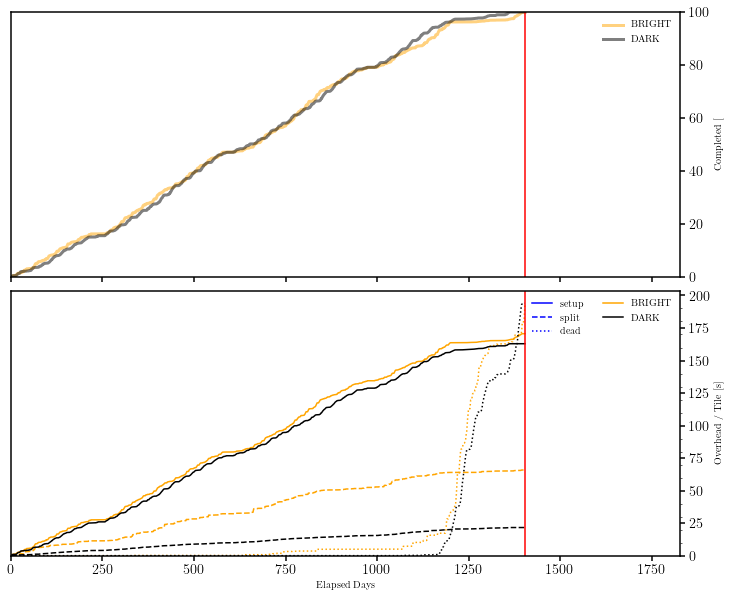

0.233 margins


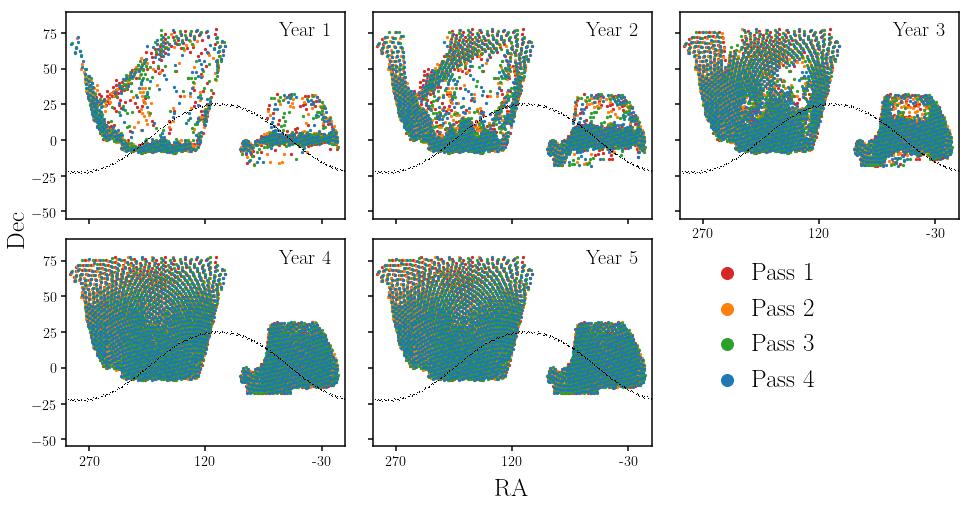

In [6]:
fig = surveysim_summary('fork_efftime180s_surveyops_simplesky')